In [1]:
# Import helper functions we're going to use
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

# importing the libraries
from keras.models import Model
from keras.layers import Flatten, Dense
#import VGG16
from keras.applications.vgg16 import VGG16
#import VGG19
from keras.applications.vgg19 import VGG19
#import ResNet50
from tensorflow.keras.applications.resnet50 import ResNet50
#from keras.preprocessing import image 
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# View an image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

def view_random_image(target_dir, target_class):
    target_folder = target_dir+target_class
    random_image = random.sample(os.listdir(target_folder), 1)
    img = mpimg.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off");
    print(f"Image shape: {img.shape}") # show the shape of the image
    return img

Image shape: (187, 269, 3)


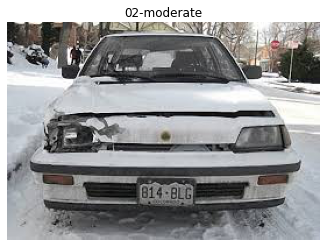

In [3]:
# View a random image 
img = view_random_image(target_dir="data/data3a/training/",
                        target_class="02-moderate")

Image shape: (183, 275, 3)


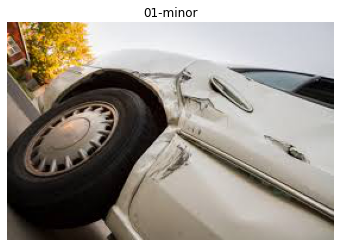

In [4]:
# View a random image 
img = view_random_image(target_dir="data/data3a/training/",
                        target_class="01-minor")

Image shape: (180, 280, 3)


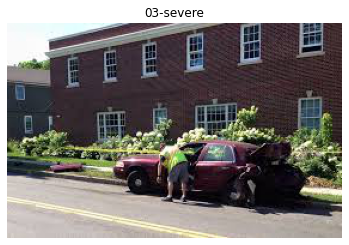

In [5]:
# View a random image 
img = view_random_image(target_dir="data/data3a/training/",
                        target_class="03-severe")

In [6]:
train="data/data3a/training/"
test="data/data3a/validation/"

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Create ImageDataGenerator training instance without data augmentation
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train,
                                               batch_size=32, # number of images to process at a time 
                                               target_size=(224, 224), # convert all images to be 224 x 224
                                               class_mode="categorical", # type of problem we're working on
                                               seed=42, shuffle=True)

valid_data = test_datagen.flow_from_directory(test,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode="categorical",
                                               seed=42, shuffle=True)

Found 979 images belonging to 3 classes.
Found 171 images belonging to 3 classes.


In [7]:
#enter name of the model, used only to use as path name for saving weights
#Resnet , #Vgg19
model_chosen = "Resnet"

#VGG16 - uncomment below code block to use VGG16 model
###
# pre_trained = VGG16(input_shape = [224, 224, 3], weights = 'imagenet', include_top = False)  
###

#VGG19 - uncomment below code block to use VGG19 model
###
# pre_trained = VGG19(input_shape = [224, 224, 3], weights = 'imagenet', include_top = False)  
###

#Resnet - uncomment below code block to use Resnet50 model
pre_trained = ResNet50(input_shape = [224, 224, 3], weights = 'imagenet', include_top = False) 

# this will exclude the initial layers from training phase as there are already been trained.
for layer in pre_trained.layers:
    layer.trainable = False

x = Flatten()(pre_trained.output)
x = Dense(128, activation = 'relu')(x)   # we can add a new fully connected layer but it will increase the execution time.
x = Dense(3, activation = 'softmax')(x)  # adding the output layer with softmax function as this is a multi label classification problem.

model = Model(inputs = pre_trained.input, outputs = x)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Fit the model 
history = model.fit(train_data, epochs=10, steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Epoch 1/10
31/31 [==============================] - 53s 2s/step - loss: 6.1462 - accuracy: 0.3912 - val_loss: 1.0888 - val_accuracy: 0.4386
Epoch 2/10
31/31 [==============================] - 50s 2s/step - loss: 1.1103 - accuracy: 0.4770 - val_loss: 1.3318 - val_accuracy: 0.4035
Epoch 3/10
31/31 [==============================] - 50s 2s/step - loss: 1.0457 - accuracy: 0.5291 - val_loss: 1.0759 - val_accuracy: 0.5146
Epoch 4/10
31/31 [==============================] - 52s 2s/step - loss: 0.8052 - accuracy: 0.6241 - val_loss: 0.9190 - val_accuracy: 0.5906
Epoch 5/10
31/31 [==============================] - 48s 2s/step - loss: 0.7762 - accuracy: 0.6496 - val_loss: 0.9180 - val_accuracy: 0.5556
Epoch 6/10
31/31 [==============================] - 48s 2s/step - loss: 0.7729 - accuracy: 0.6374 - val_loss: 1.0395 - val_accuracy: 0.5614
Epoch 7/10
31/31 [==============================] - 47s 2s/step - loss: 0.7454 - accuracy: 0.6721 - val_loss: 0.9324 - val_accuracy: 0.5556
Epoch 8/10
31/31 [==

In [8]:
save_path = "saved_checkpoints/" + model_chosen + "car_damage_severity_model.h5"

model.save(save_path)

In [9]:
# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224):
    
    # Read in target file (an image)
    img = tf.io.read_file(filename)

    # Decode the read file into a tensor & ensure 3 colour channels 
    img = tf.image.decode_image(img, channels=3)

    # Resize the image (to the same size our model was trained on
    img = tf.image.resize(img, size = [img_shape, img_shape])

    # Rescale the image (get all values between 0 and 1)
    img = img/255.
    return img


import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

def pred_and_plot(model, filename):
    
    # Import the target image and preprocess it
    img = load_and_prep_image(filename)
    
    # Make a prediction
    pred = model.predict(tf.expand_dims(img, axis=0))
    pred=pred.argmax()

    # Plot the image and predicted class
    plt.imshow(img)
    plt.title(f"Prediction: {pred}")
    plt.axis(False)

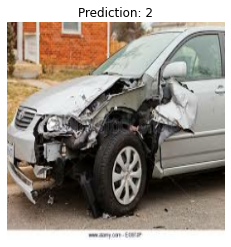

In [10]:
target_dir="data/data3a/training/"

target_class="03-severe"

target_folder = target_dir+target_class
random_image = random.sample(os.listdir(target_folder), 1)[0]

# Test our model 
pred_and_plot(model, target_folder + "/" + random_image)


In [ ]:
test_data = test_datagen.flow_from_directory(test,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode="categorical",
                                               seed=42, shuffle=False)

In [11]:
prediction = model.predict(test_data)

In [13]:
y_pred = []
for each in prediction:
    max_value = max(each)

    max_index = list(each).index(max_value)

    y_pred.append(max_index)

In [14]:
conf_matrix = confusion_matrix(y_pred=y_pred, y_true=valid_data.labels)

In [15]:
conf_matrix

array([[39,  0,  9],
       [37,  0, 18],
       [19,  0, 49]], dtype=int64)

[Text(0, 0.5, 'Front'), Text(0, 1.5, 'Rear'), Text(0, 2.5, 'Side')]

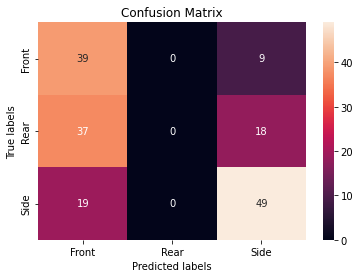

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(conf_matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Front', 'Rear', 'Side']); ax.yaxis.set_ticklabels(['Front', 'Rear', 'Side'])

In [17]:
print(classification_report(y_true=valid_data.labels, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.41      0.81      0.55        48
           1       0.00      0.00      0.00        55
           2       0.64      0.72      0.68        68

    accuracy                           0.51       171
   macro avg       0.35      0.51      0.41       171
weighted avg       0.37      0.51      0.42       171



C:\Users\mishr\anaconda3\envs\new\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mishr\anaconda3\envs\new\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mishr\anaconda3\envs\new\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
